In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import os
import csv
import wrangle_zillow
import prepare
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

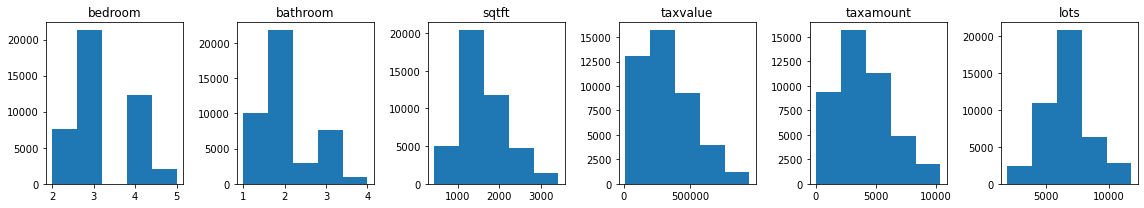

In [2]:
# load zillow data
zillow_train,zillow_validate,zillow_test=wrangle_zillow.wrangle_zillow(1.5)

In [3]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24241 entries, 29999 to 13860
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom          24241 non-null  float64
 1   bathroom         24241 non-null  float64
 2   sqtft            24241 non-null  float64
 3   taxvalue         24241 non-null  float64
 4   yearbuilt        24241 non-null  object 
 5   taxamount        24241 non-null  float64
 6   fips             24241 non-null  object 
 7   lots             24241 non-null  float64
 8   zipcode          24241 non-null  object 
 9   assessmentyear   24241 non-null  object 
 10  transactiondate  24241 non-null  object 
 11  taxrate          24241 non-null  object 
dtypes: float64(6), object(6)
memory usage: 2.4+ MB


In [4]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,24241.0,3.197228,0.779588,2.00,3.00,3.00,4.00,5.00
bathroom,24241.0,2.023720,0.700037,1.00,2.00,2.00,2.50,4.00
sqtft,24241.0,1617.265501,543.071357,447.00,1217.00,1522.00,1926.00,3423.00
taxvalue,24241.0,322274.319376,196531.203511,11291.00,169586.00,291172.00,445000.00,948243.00
taxamount,24241.0,3996.753831,2206.987420,49.18,2332.66,3686.19,5378.42,10393.47
lots,24241.0,6658.314343,1811.354324,1890.00,5514.00,6499.00,7590.00,11822.00


In [5]:
# the target will be taxamount

In [6]:
x_train, y_train = zillow_train.select_dtypes('float').drop(columns='taxamount'),zillow_train.taxamount
x_validate, y_validate = zillow_validate.select_dtypes('float').drop(columns='taxamount'),zillow_validate.taxamount
x_test, y_test = zillow_test.select_dtypes('float').drop(columns='taxamount'),zillow_test.taxamount

In [7]:
scaler=MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_validate_scaled = pd.DataFrame(scaler.fit_transform(x_validate), index=x_validate.index, columns=x_validate.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), index=x_test.index, columns=x_test.columns)

In [8]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
y_train['baseline'] = y_train['taxamount'].mean()
y_validate['baseline'] = y_validate['taxamount'].mean()

# predict median
y_train['taxamount_med'] = y_train['taxamount'].median()
y_validate['taxamount_med'] = y_validate['taxamount'].median()

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxamount, y_train.baseline)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxamount, y_validate.baseline)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# RMSE of median
rmse_train = mean_squared_error(y_train.taxamount, y_train.taxamount_med)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxamount, y_validate.taxamount_med)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))



RMSE using Mean
Train/In-Sample:  2206.94 
Validate/Out-of-Sample:  2194.97
RMSE using Median
Train/In-Sample:  2228.69 
Validate/Out-of-Sample:  2213.69


In [9]:
models = pd.DataFrame(
[
    {
        'model': 'baseline',
        'rmse': mean_squared_error(y_train['taxamount'], y_train.baseline)**(1/2),
        'r^2': explained_variance_score(y_train['taxamount'], y_train.baseline)
    
    }
])
models

,model,rmse,r^2
0,baseline,2206.941897,0.0


In [10]:
def modeling(model, 
                  x_train, 
                  y_train, 
                  x_validate, 
                  y_validate, 
                  scores=models):
    model.fit(x_train, y_train.taxamount)
    in_sample_pred = model.predict(x_train)
    out_sample_pred = model.predict(x_validate)
    model_name = input('model name?')
    y_train[model_name] = in_sample_pred
    y_validate[model_name] = out_sample_pred
    print(y_validate.shape)
    print(out_sample_pred.shape)
    rmse_val = mean_squared_error(
    y_validate.taxamount, out_sample_pred, squared=False)
    r_squared_val = explained_variance_score(
        y_validate.taxamount, out_sample_pred)
    return models.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    
    }, ignore_index=True)

In [11]:
models = modeling(LinearRegression(normalize=True), 
                  x_train_scaled, 
                  y_train, 
                  x_validate_scaled, 
                  y_validate, 
                  scores=models)

model name?OLS
(10389, 4)
(10389,)


In [12]:
models = modeling(LassoLars(alpha=1.0), 
                  x_train_scaled, 
                  y_train, 
                  x_validate_scaled, 
                  y_validate, 
                  scores=models)

model name?LARS
(10389, 5)
(10389,)


In [13]:
polyfeats = PolynomialFeatures(degree=2)
x_train_quad = polyfeats.fit_transform(x_train_scaled)
x_val_quad = polyfeats.transform(x_validate_scaled)
models = modeling(LinearRegression(), 
                  x_train_quad, 
                  y_train, 
                  x_val_quad, 
                  y_validate, 
                  scores=models)

model name?POLY
(10389, 6)
(10389,)


In [14]:
models = modeling(TweedieRegressor(power=1, alpha=0), 
                  x_train_scaled, 
                  y_train, 
                  x_validate_scaled, 
                  y_validate, 
                  scores=models)

model name?TWE
(10389, 7)
(10389,)


In [15]:
models

,model,rmse,r^2
0,baseline,2206.941897,0.000000
1,OLS,520.202532,0.943849
2,LARS,545.997355,0.938138
3,POLY,515.659425,0.944826
4,TWE,864.479268,0.844886


In [16]:
kbest = SelectKBest(f_regression, k=3)
kbest.fit(x_train_scaled, y_train.taxamount)
mask = x_train_scaled.columns[kbest.get_support()].to_list()

In [17]:
models = modeling(LinearRegression(), 
                  x_train_scaled[mask], 
                  y_train, 
                  x_validate_scaled[mask], 
                  y_validate, 
                  scores=models)

model name?KBEST
(10389, 8)
(10389,)


In [18]:
models

,model,rmse,r^2
0,baseline,2206.941897,0.000000
1,OLS,520.202532,0.943849
2,LARS,545.997355,0.938138
3,POLY,515.659425,0.944826
4,TWE,864.479268,0.844886
5,KBEST,520.622872,0.943758


In [19]:
models.rmse.min()

515.6594248317249

In [20]:
models['r^2'].max()

0.9448261488772965

In [21]:
polyfeats = PolynomialFeatures(degree=2)
x_test_quad = polyfeats.fit_transform(x_test_scaled)

In [22]:
def modeling(model, 
                  x_test, 
                  y_test, 
                  scores=models):
    model.fit(x_test, y_test)
    in_sample_pred = model.predict(x_test)
    model_name = input('model_name?')
    y_test[model_name] = in_sample_pred
    rmse_val = mean_squared_error(
    y_test, in_sample_pred, squared=False)**(1/2)
    r_squared_val = explained_variance_score(
        y_test, in_sample_pred)
    return models.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    
    }, ignore_index=True)

In [23]:
x_test_scaled=x_test_scaled.dropna()
x_test_scaled

,bedroom,bathroom,sqtft,taxvalue,lots
35943,0.000000,0.000000,0.117587,0.238733,0.454426
41461,0.333333,0.333333,0.352417,0.481175,0.451909
5930,0.333333,0.000000,0.171066,0.506908,0.423003
31798,0.666667,0.500000,0.548852,0.201042,0.414644
426,0.333333,0.333333,0.282139,0.414779,0.425622
...,...,...,...,...,...
37717,0.333333,0.333333,0.285910,0.259607,0.347668
10943,0.333333,0.500000,0.640384,0.676088,0.201833
25220,1.000000,1.000000,0.521083,0.373113,0.342028
11686,0.333333,0.333333,0.567707,0.150565,0.604492


In [24]:
y_test

35943    3252.11
41461    5427.46
5930     5750.34
31798    2665.18
426      4898.35
          ...   
37717    3336.47
10943    9988.22
25220    4502.59
11686    1516.98
56009    2376.47
Name: taxamount, Length: 8658, dtype: float64

In [28]:
polyfeats = PolynomialFeatures(degree=2)
model=LinearRegression()
model.fit(x_test, y_test)
x_test = polyfeats.fit_transform(x_test_scaled)

In [29]:
rmse_val = mean_squared_error(
    y_test, model.predict(x_test), squared=False)
r_squared_val = explained_variance_score(
        y_test, model.predict(x_test))

In [30]:
rmse_val,r_squared_val

(498.86122454941614, 0.9473226885867507)